# Robotics Assessment 2

## Student Info

**Student ID Number:** 201663463<br>
**Name:** Haseeb Akbar<br>
**Email:** od21h2a@leeds.ac.uk

###  Summary and Introduction (3) 
Need to create three trainable robot navigation models for this task. Your robot models will navigate in an indoor environment without hitting the walls to reach a goal destination near one of the pillars in the environment. 


command to run: roslaunch turtlebot3_gazebo turtlebot3_assessment2.launch

### ENV Class
Creating a suitable Env class that communicates with the provided environment and isolates the ROS requirements from the RL solution (10)

### Robot model 1: Tabular Solution

Use a tabular RL method (2)
Correctly divide the environment into a grid and use odometry only for state representation (2)
Use a suitable reward function (2)
Parameters tuning and justification (2) 
Learning plots, model’s success rate (2)
Analysis of the results (2) 

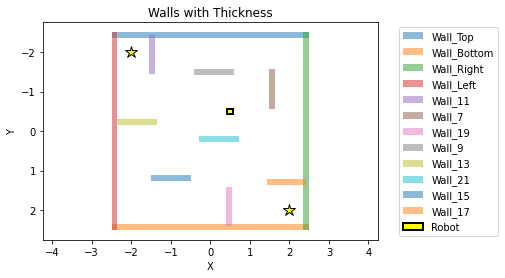

In [9]:
import matplotlib.pyplot as plt

walls = {
       "Wall_Top": {"left_x": 2.5, "right_x": -2.5, "bottom_y": -2.35, "top_y": -2.5},
       "Wall_Bottom": {"left_x": 2.5, "right_x": -2.5, "bottom_y": 2.5, "top_y": 2.35},
       "Wall_Right": {"left_x": 2.5, "right_x": 2.35, "bottom_y": 2.5, "top_y": -2.5},
       "Wall_Left": {"left_x": -2.5, "right_x": -2.35, "bottom_y": 2.5, "top_y": -2.5},
        ## Verticals
       "Wall_11": {"left_x": -1.392, "right_x": -1.542, "bottom_y": -1.437, "top_y": -2.437},
       "Wall_7": {"left_x": 1.623, "right_x": 1.473, "bottom_y": -0.564, "top_y": -1.564},
       "Wall_19": {"left_x": 0.5382, "right_x": 0.3882, "bottom_y": 2.41128, "top_y": 1.41128},
       ## Horizontals
       "Wall_9":{"left_x": 0.592, "right_x": -0.408, "bottom_y": -1.427, "top_y": -1.577},
       "Wall_13":{"left_x": -1.36, "right_x": -2.36, "bottom_y": -0.145, "top_y": -0.295},
       "Wall_21":{"left_x": 0.715, "right_x": -0.285, "bottom_y": 0.279, "top_y": 0.129},
       "Wall_15":{"left_x": -0.502, "right_x": -1.502, "bottom_y": 1.27, "top_y": 1.12},
       "Wall_17":{"left_x": 2.43, "right_x": 1.43, "bottom_y": 1.363, "top_y": 1.213},
}

robot = {
       "Robot":{"left_x": 0.43017, "right_x":0.57017 , "bottom_y": -0.570048, "top_y": -0.430048},
}

goals = {
    "Goal1":{"left_x": -2.125, "right_x":-1.875, "bottom_y": -2.125, "top_y": -1.875},
    "Goal2":{"left_x": 1.875, "right_x":2.125, "bottom_y": 1.875, "top_y": 2.125},
}

fig, ax = plt.subplots()

# Draw the walls
for wall, coords in walls.items():
    ax.fill([coords["left_x"], coords["right_x"], coords["right_x"], coords["left_x"]],
            [coords["bottom_y"], coords["bottom_y"], coords["top_y"], coords["top_y"]],
            label=wall, alpha=0.5)

# Draw the robot
for r, robot_coords in robot.items():
    ax.fill([robot_coords["left_x"], robot_coords["right_x"], robot_coords["right_x"], robot_coords["left_x"]],
            [robot_coords["bottom_y"], robot_coords["bottom_y"], robot_coords["top_y"], robot_coords["top_y"]],
            label=r, alpha=1, color="yellow", linewidth=2, linestyle="-", edgecolor="black")
    
# Draw the goals
for g, goal_coords in goals.items():
    ax.plot((goal_coords["left_x"] + goal_coords["right_x"])/2, (goal_coords["bottom_y"] + goal_coords["top_y"])/2,
            marker="*", markersize=12, markerfacecolor="yellow", markeredgecolor="black")
    
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Walls with Thickness")
plt.axis("equal")

# Invert the y-axis
ax.invert_yaxis()

plt.show()


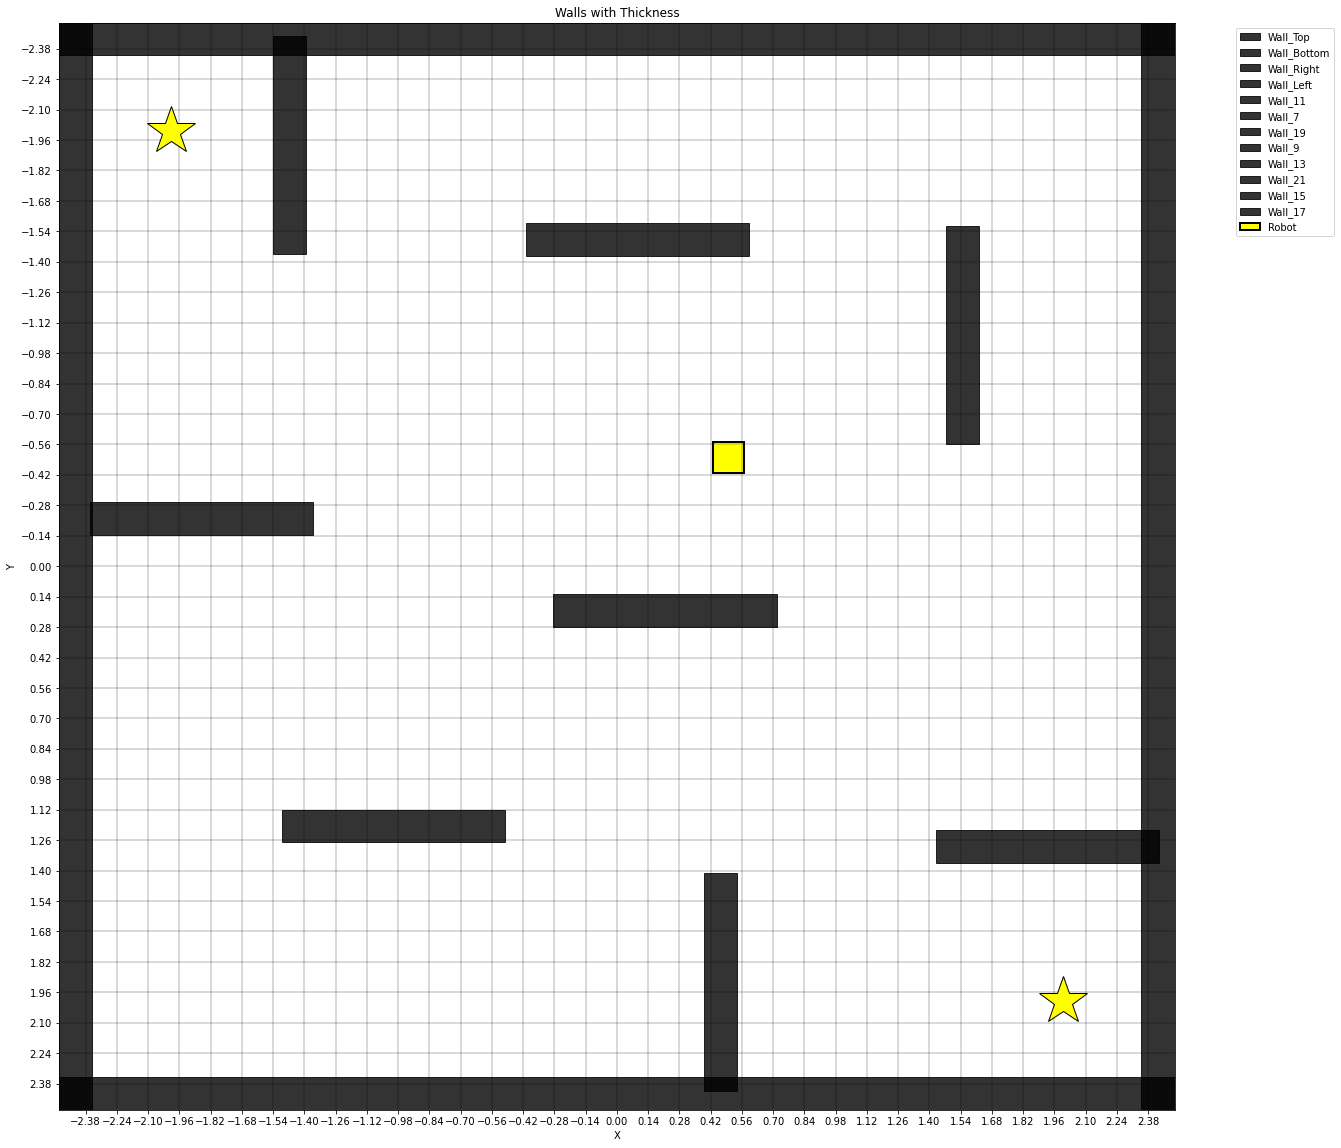

In [10]:
import matplotlib.pyplot as plt

walls = {
       "Wall_Top": {"left_x": 2.5, "right_x": -2.5, "bottom_y": -2.35, "top_y": -2.5},
       "Wall_Bottom": {"left_x": 2.5, "right_x": -2.5, "bottom_y": 2.5, "top_y": 2.35},
       "Wall_Right": {"left_x": 2.5, "right_x": 2.35, "bottom_y": 2.5, "top_y": -2.5},
       "Wall_Left": {"left_x": -2.5, "right_x": -2.35, "bottom_y": 2.5, "top_y": -2.5},
    
                ## Verticals
       "Wall_11": {"left_x": -1.392, "right_x": -1.542, "bottom_y": -1.437, "top_y": -2.437},
       "Wall_7": {"left_x": 1.623, "right_x": 1.473, "bottom_y": -0.564, "top_y": -1.564},
       "Wall_19": {"left_x": 0.5382, "right_x": 0.3882, "bottom_y": 2.41128, "top_y": 1.41128},
       ## Horizontals
       "Wall_9":{"left_x": 0.592, "right_x": -0.408, "bottom_y": -1.427, "top_y": -1.577},
       "Wall_13":{"left_x": -1.36, "right_x": -2.36, "bottom_y": -0.145, "top_y": -0.295},
       "Wall_21":{"left_x": 0.715, "right_x": -0.285, "bottom_y": 0.279, "top_y": 0.129},
       "Wall_15":{"left_x": -0.502, "right_x": -1.502, "bottom_y": 1.27, "top_y": 1.12},
       "Wall_17":{"left_x": 2.43, "right_x": 1.43, "bottom_y": 1.363, "top_y": 1.213},
}

robot = {
       "Robot":{"left_x": 0.43017, "right_x":0.57017 , "bottom_y": -0.570048, "top_y": -0.430048},
}

goals = {
    "Goal1":{"left_x": -2.125, "right_x":-1.875, "bottom_y": -2.125, "top_y": -1.875},
    "Goal2":{"left_x": 1.875, "right_x":2.125, "bottom_y": 1.875, "top_y": 2.125},
}


# Define grid parameters
grid_size = 0.14
x_min, x_max = -2.5, 2.5
y_min, y_max = -2.5, 2.5
x_ticks = [i*grid_size for i in range(int(x_min/grid_size), int(x_max/grid_size)+1)]
y_ticks = [i*grid_size for i in range(int(y_min/grid_size), int(y_max/grid_size)+1)]

fig, ax = plt.subplots(figsize=(20, 20))

# Draw the grid
for x in x_ticks:
    ax.axvline(x, linestyle='-', color='black', alpha=0.2)
for y in y_ticks:
    ax.axhline(y, linestyle='-', color='black', alpha=0.2)

# Draw the walls
for wall, coords in walls.items():
    ax.fill([coords["left_x"], coords["right_x"], coords["right_x"], coords["left_x"]],
            [coords["bottom_y"], coords["bottom_y"], coords["top_y"], coords["top_y"]],
            label=wall, alpha=0.8, color="black")
    
# Draw the robot
for r, robot_coords in robot.items():
    ax.fill([robot_coords["left_x"], robot_coords["right_x"], robot_coords["right_x"], robot_coords["left_x"]],
            [robot_coords["bottom_y"], robot_coords["bottom_y"], robot_coords["top_y"], robot_coords["top_y"]],
            label=r, alpha=1, color="yellow", linewidth=2, linestyle="-", edgecolor="black")
    
# Draw the goals
for g, goal_coords in goals.items():
    ax.plot((goal_coords["left_x"] + goal_coords["right_x"])/2, (goal_coords["bottom_y"] + goal_coords["top_y"])/2,
            marker="*", markersize=50, markerfacecolor="yellow", markeredgecolor="black")

plt.xlabel("X")
plt.ylabel("Y")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Walls with Thickness")
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.axis([x_min, x_max, y_min, y_max])

# Invert the y-axis
ax.invert_yaxis()

plt.show()

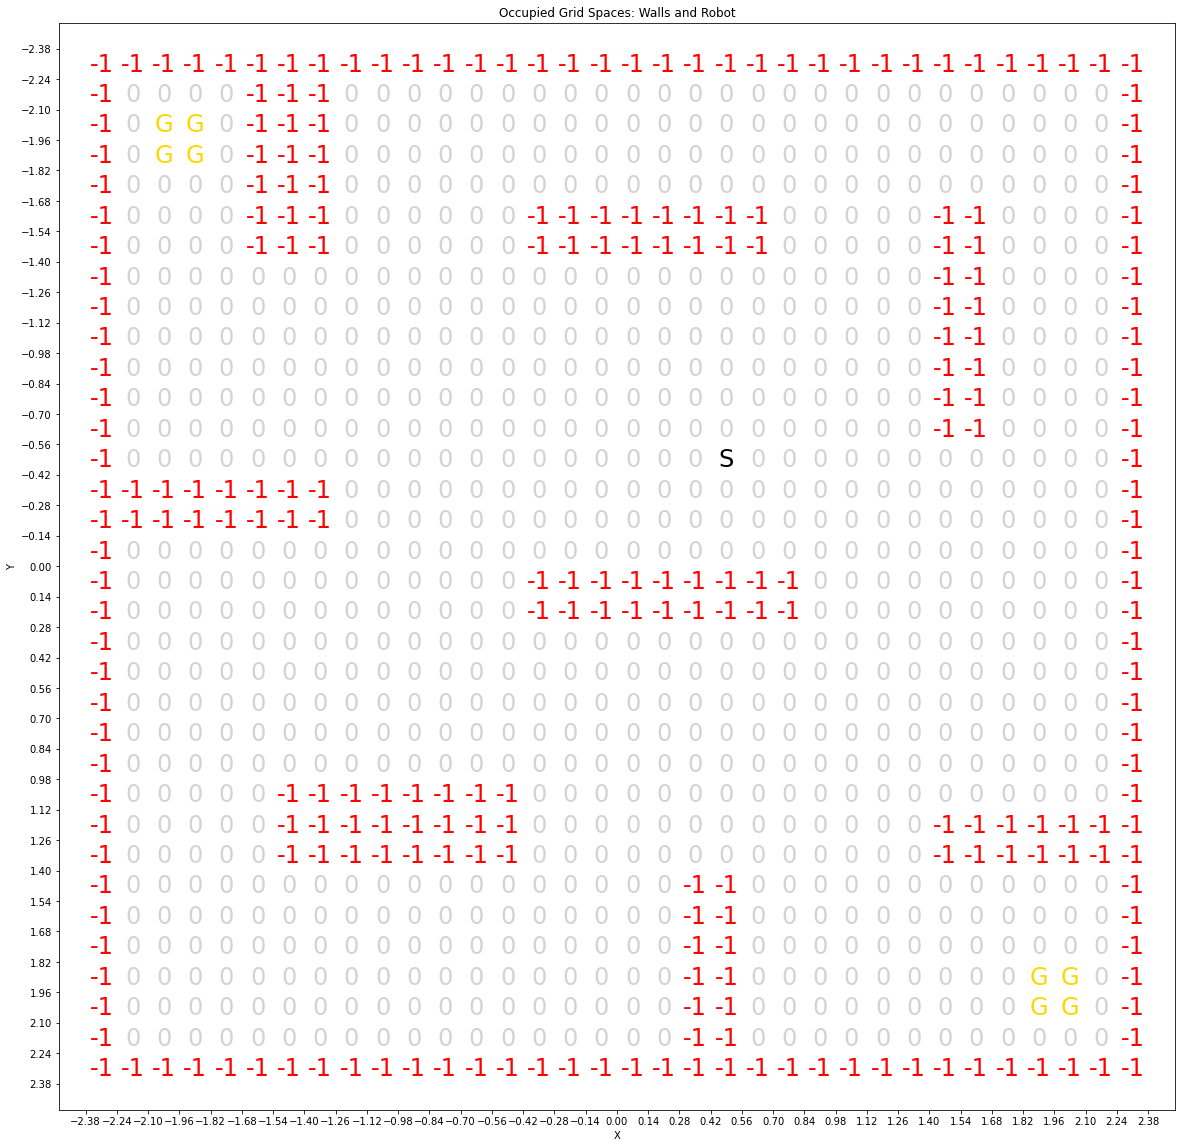

In [11]:
import matplotlib.pyplot as plt
import numpy as np

walls = {
       "Wall_Top": {"left_x": 2.5, "right_x": -2.5, "bottom_y": -2.35, "top_y": -2.5},
       "Wall_Bottom": {"left_x": 2.5, "right_x": -2.5, "bottom_y": 2.5, "top_y": 2.35},
       "Wall_Right": {"left_x": 2.5, "right_x": 2.35, "bottom_y": 2.5, "top_y": -2.5},
       "Wall_Left": {"left_x": -2.5, "right_x": -2.35, "bottom_y": 2.5, "top_y": -2.5},
    
                ## Verticals
       "Wall_11": {"left_x": -1.392, "right_x": -1.542, "bottom_y": -1.437, "top_y": -2.437},
       "Wall_7": {"left_x": 1.623, "right_x": 1.473, "bottom_y": -0.564, "top_y": -1.564},
       "Wall_19": {"left_x": 0.5382, "right_x": 0.3882, "bottom_y": 2.41128, "top_y": 1.41128},
       ## Horizontals
       "Wall_9":{"left_x": 0.592, "right_x": -0.408, "bottom_y": -1.427, "top_y": -1.577},
       "Wall_13":{"left_x": -1.36, "right_x": -2.36, "bottom_y": -0.145, "top_y": -0.295},
       "Wall_21":{"left_x": 0.715, "right_x": -0.285, "bottom_y": 0.279, "top_y": 0.129},
       "Wall_15":{"left_x": -0.502, "right_x": -1.502, "bottom_y": 1.27, "top_y": 1.12},
       "Wall_17":{"left_x": 2.43, "right_x": 1.43, "bottom_y": 1.363, "top_y": 1.213},
}

robot = {
       "Robot":{"left_x": 0.43017, "right_x":0.57017 , "bottom_y": -0.570048, "top_y": -0.430048},
}

goals = {
    "Goal1":{"left_x": -2.125, "right_x":-1.875, "bottom_y": -2.125, "top_y": -1.875},
    "Goal2":{"left_x": 1.875, "right_x":2.125, "bottom_y": 1.875, "top_y": 2.125},
}


def is_occupied(x, y, walls, robot, goals, grid_size):
    for _, coords in walls.items():
        within_x_range = (x + grid_size >= coords["right_x"] and x <= coords["left_x"]) or (x + grid_size >= coords["left_x"] and x <= coords["right_x"])
        within_y_range = (y + grid_size >= coords["top_y"] and y <= coords["bottom_y"])
        if within_x_range and within_y_range:
            return "wall"
    for _, coords in robot.items():
        if coords["left_x"] <= x + grid_size / 2 <= coords["right_x"] and coords["bottom_y"] <= y + grid_size / 2 <= coords["top_y"]:
            return "robot"
    for _, coords in goals.items():
        if coords["left_x"] <= x + grid_size / 2 <= coords["right_x"] and coords["bottom_y"] <= y + grid_size / 2 <= coords["top_y"]:
            return "goal"
    return False

fig, ax = plt.subplots(figsize=(20, 20))

# Display 0 for free spaces, -1 for occupied spaces, 'g' for robot, and 'G' for goal
for x in x_ticks[:-1]:
    for y in y_ticks[:-1]:
        occupancy = is_occupied(x, y, walls, robot, goals, grid_size)
        if occupancy == "wall":
            text, color = -1, 'red'
        elif occupancy == "robot":
            text, color = 'S', 'black'
        elif occupancy == "goal":
            text, color = 'G', 'Gold'
        else:
            text, color = 0, 'lightgray'
        ax.text(x + grid_size / 2, y + grid_size / 2, str(text), fontsize=24,
                ha='center', va='center', color=color)


plt.xlabel("X")
plt.ylabel("Y")
plt.title("Occupied Grid Spaces: Walls and Robot")
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.axis([x_min, x_max, y_min, y_max])

# Invert the y-axis
ax.invert_yaxis()

plt.show()


In [108]:
import numpy as np
import random
import time
import math
import io
import sys
import os


from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib import colors
from numpy.random import rand, seed, randint, choice
from random import choices, sample
from tqdm import trange, tqdm

In [226]:
class Grid:
    def __init__(self, gridsize=[35,35], nA=4, s0=720, goals=None, Vstar=None):
        self.rows = gridsize[0]
        self.cols = gridsize[1]
        self.nS = self.cols*self.rows # we assume cells IDs go left to right and top down
        self.goals = [self.nS-1, self.nS-1] if goals is None else ([goals[0], goals[0]] if len(goals)==1 else goals)
        self.Vstar = Vstar # optimal state value, needed for some of the environments
        self.s0 = s0
        self.s = s0
        self.trace = [self.s0]
        
        # actions ---------------------------------------------------------------------       
        cols = self.cols
        self.actions_2 = [-1, +1]
        self.actions_4 = [-1, +1, -cols, +cols]     # left, right, down and up
        self.actions_8 = [-1, +1, -cols, +cols, -1-cols, -1+cols, 1-cols, 1+cols] # left-down, left-up, right-down, right-up
 
        self.nA = nA
        if nA==2: self.actions = self.actions_2
        if nA==4: self.actions = self.actions_4
        if nA==8: self.actions = self.actions_8
        
        # rewards types-----------------------------------------------------------------
        self.nR = 4
        self.rewards = [0, 1, 0, -100] # intermediate, goal1, goal2, cliff
        self.obstacles, self.cliffs = [], [] # lists that will be checked when doing actions
        
        
    def reset(self, withtrace=True):
        self.s = self.s0
        if withtrace: self.trace = [self.s0]
        return self.s_()
    #-----------------------------------------rewards related-------------------------------------------
    def rewards_set(self):
        return np.array(list(set(self.rewards)))
        
    def reward(self):
        stype = self.stype()
        reward = self.rewards[stype]
        if stype==3: self.reset(False)    # s in cliffs
        return reward, 2>=stype>=1        # either at goal1 or goal2
    
    #-----------------------------------------actions related-------------------------------------------
    def invalid(self, s,a):
        cols = self.cols
        # invalid moves are 
        # 1. off grid boundaries
        # 2. off the right edge (last and is for right up and down diagonal actions)
        # 3. off the left edge  (last and is for left  up and down diagonal actions)
        # 4. into an obstacle
        return      not(0<=(s+a)<self.nS) \
                    or (s%cols!=0 and (s+a)%cols==0 and (a==1 or a==cols+1 or a==-cols+1))  \
                    or (s%cols==0 and (s+a)%cols!=0 and (a==-1 or a==cols-1 or a==-cols-1)) \
                    or (s+a) in self.obstacles

    def step(self, a, *args):
        a = self.actions[a]
        if not self.invalid(self.s,a): self.s += a
        
        self.trace.append(self.s)
        reward, done = self.reward()       # must be done in this order for the cliff reset to work properly
        return self.s_(), reward, done, {} # empty dict for compatibility
    
    #-----------------------------------------state related-------------------------------------------
    # useful for inheritance, observation can be a state (index) or a state representation (vector or image)
    def s_(self):
        return self.s
    
    # returns the number of states that are available for the agent to occupy
    def nS_available(self):
        return self.nS - len(self.obstacles)
    
    #-----------------------------------------goals related-------------------------------------------
    # returns the type of the current state (0: intermediate, 1 or 2 at goal1 or goal2, 3:off cliff)
    def stype(self):
        s, goals, cliffs = self.s, self.goals, self.cliffs
        # the order is significant and must not be changed
        return [s not in goals+cliffs, s==goals[0], s==goals[1], s in cliffs].index(True)
    
    def isatgoal(self):
        return self.stype() in [1,2] # either at goal1 or goal2


In [356]:
class Grid(Grid):
    def __init__(self, pause=0, figsize=None, **kw):
        super().__init__(**kw)
        
        self.figsize = figsize # desired figure size        
        self.fig = None        # figure handle, may have several subplots        
        self.ax0 = None        # Grid subplot handle
        
        self.pause = pause     # pause to slow animaiton
        self.arrows = None     # policy arrows (direction of action with max value)
        
        # assuming env is not dynamic, otherwise should be moved to render() near self.to_pos(self.s)
        self.start = self.to_pos(self.s0)         
        self.goal1 = self.to_pos(self.goals[0])
        self.goal2 = self.to_pos(self.goals[1])
        self.cmap = colors.ListedColormap(['w', 'darkgray'])

    # state representation function that converts 1-d list of state representation into a 2-d coordinates
    def to_pos(self, s):
        return [s%self.cols + 1, s//self.cols + 1]

    #------------------------------------------initialise------------------------------------------------- 
    def init_cells(self, cells): 
        Cells = np.zeros((self.rows+1, self.cols+1),  dtype=bool)
        Cells[0,0] = True # to populate for drawing 
        poses = self.to_pos(np.array(cells))
        Cells[poses[1], poses[0]] = True
        return Cells[1:,1:]
    
    #------------------------------------------render ✍️-------------------------------------------------
    # this function is to protect render() called twice for Gridi
    def render(self, **kw):
        self.render__(**kw)

    # we have placed most of the render overhead in the render() function to keep the rest efficient.
    # this funciton must not be called directly instead render() is to be called
    def render__(self, underhood='', pause=None, label='', subplot=131, large=False, 
               animate=True, image=False, saveimg=False,  **kw):
        
        if self.figsize is None:
            if   self.rows==1:             self.figsize = (15,.5) 
            elif underhood=='Q':           self.figsize = (20, 10)
            elif underhood=='V' and large: self.figsize = (30, 25)
            else:                          self.figsize = (17, 3)
        if image: self.figsize = (17, 3) # changing the default figure size is dissallowed for games

        if self.fig is None: self.fig = plt.figure(1)
        #if self.ax0 is None: self.ax0 = plt.subplot(subplot)
        plt.gcf().set_size_inches(self.figsize[0], self.figsize[1])
            
        #if   animate: self.ax0 = plt.subplot(subplot)
        #elif image:   plt.cla() 
        self.ax0 = plt.subplot(subplot)
        if image and not animate: plt.cla()
           
        
        # get hooks for self properties
        rows, cols = self.rows, self.cols
        pos, start, goal1, goal2 = self.to_pos(self.s), self.start, self.goal1, self.goal2
        
        pause = self.pause if pause is None else pause
        
        # a set of properties for the grid subplot
        
        prop = {'xticks': np.linspace(0, cols, cols+1),     'xticklabels':[],
                'yticks': np.linspace(0, rows, rows+1)+.01, 'yticklabels':[],
                'xlim':(0, cols), 'ylim':(0, rows), 'xlabel': label} # useful info
        self.ax0.update(prop)
        self.ax0.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
        if self.style not in ['maze', 'cliff']: self.ax0.grid(True)

        # robot visuals :-)
        mrgn = .5
        eyes = '˚-˚' if underhood!='Q' else '' 
        body = 'ro'  if underhood!='Q' else 'co'
        
        # plot goals and start state
        for (x,y), s in zip([goal1, goal2, start], ['G', 'G', 'S']):
            self.ax0.text(x-mrgn, y-mrgn, s, fontsize=20)
        
        # plot robot
        self.ax0.text(pos[0]-mrgn-.2, pos[1]-mrgn-.15, eyes, fontsize=10)
        self.ax0.plot(pos[0]-mrgn,    pos[1]-mrgn,     body, markersize=15) 
        #self.ax0.plot(pos, body, markersize=15) # this causes the body not be up to date in later lessons

        # to reduce overhead, pre-store coordinates in the grid only when render is needed
        if self.X is None: 
            self.X, self.Y = np.array(self.to_pos(np.arange(self.nS))) 
            self.Ox, self.Oy = np.arange(cols+1), np.arange(rows+1)

        # underhood obstacles and a cliffs
        if self.style=='maze':  
            if self.Obstacles is None: self.Obstacles = self.init_cells(self.obstacles)
            self.ax0.pcolormesh(self.Ox, self.Oy, self.Obstacles, edgecolors='lightgray', cmap=self.cmap)
        
        if self.style=='cliff': 
            if self.Cliffs is None: self.Cliffs = self.init_cells(self.cliffs)
            self.ax0.pcolormesh(self.Ox, self.Oy, self.Cliffs, edgecolors='lightgray', cmap=self.cmap)

        # this means that the user wants to draw the policy arrows (actions)
        if 'Q' in kw and underhood=='': underhood='maxQ'
        
        # a placeholder function for extra rendering jobs
        render_ = getattr(self, 'render_'+ underhood)(**kw)
        # windy style needs a bespoke rendering
        if self.style =='windy': self.render_windy()

        if image: self.render_image(saveimg=saveimg)
            
        # to animate clear and plot the Grid
        if animate: clear_output(wait=True); plt.show(); time.sleep(pause)
        #else: plt.subplot(subplot)
    
    #-------------------------helper functions for rendering policies and value functions---------------------
    def render_(self, **kw):
        pass # a placeholder for a another drawing if needed
    
    def render_image(self, **kw):
        pass # a placeholder for capturing and saving Grid as images
    
    # renders all states numbers' reprsentation on the grid
    def render_states(self, **kw):
        X,Y  = self.X, self.Y
        for s in range(self.nS): 
            self.ax0.text(X[s]-.5,Y[s]-.5, s, fontsize=13, color='g')


In [432]:
class Grid(Grid):
    def __init__(self, reward='',  style='', **kw):
        super().__init__(**kw)
    
        # explicit rewards for[intermediate,goal0,goal1, cliff] states
        self.reward_    = [0,    1,   0, -100] # this is the default value for the rewards
        self.cliffwalk  = [-1,  -1,  -1, -100]
        self.randwalk   = [ 0,   0,   1,    0]
        self.randwalk_  = [ 0,  -1,   1,    0]
        self.reward0    = [-1,   0,   0,   -1]
        self.reward_1   = [-1,  -1,  -1,   -1]
        self.reward1    = [-1,   1,   1,   -1]
        self.reward10   = [-1,  10,  10,   -1]
        self.reward100  = [-1, 100, 100,   -1]
        

        if reward: self.rewards  = getattr(self, reward)
        self.style = style
        
        # accommodating grids styles -------------------------------------------------------------
        self.X, self.Y = None, None
        self.Obstacles = self.Cliffs = 0 # np arrays for display only, related to self.obstacles, self.cliffs
        self.wind = [0]*10               # [0,0,0,0,0,0,0,0,0,0]
        
        if self.style=='cliff':
            self.Cliffs = None           # for displaying only, to be filled when render() is called
            self.cliffs = list(range(1,self.cols-1))
            
        elif self.style=='maze':
            self.Obstacles = None        # for displaying only, to be filled when render() is called
            rows = self.rows
            cols = self.cols
            midc = int(cols/2)
            
            ## WALLS
            #######################
            #######################
            #######################
            wall1 = list(range(0, 2+(rows-1)*cols, cols))    # set of vertical obstacles near the start
            wall3 = list(range(34,-2+(rows+1)*cols, cols))   # set of vertical obstacles near the end
            
            wall2 = list(range(0, 34))                   # set of horizontal obstacles
            wall4 = list(range(1190, 1224))                   # set of horizontal obstacles
            
            wall5 = list(range(630, 638))    # set of vertical obstacles near the start
            wall6 = list(range(665, 673))    # set of vertical obstacles near the start
            
            wall7 = list(range(1029, 1037))    # set of vertical obstacles near the start
            wall8 = list(range(994, 1002))    # set of vertical obstacles near the start
            
            wall9 = list(range(574, 583))    # set of vertical obstacles near the start
            wall10 = list(range(539, 548))    # set of vertical obstacles near the start
            
            wall11 = list(range(251, 259))    # set of vertical obstacles near the start
            wall12 = list(range(286, 294))    # set of vertical obstacles near the start
            wall13 = list(range(321, 329))    # set of vertical obstacles near the start
            
            wall14 = list(range(272, 279))    # set of vertical obstacles near the start
            wall15 = list(range(307, 314))    # set of vertical obstacles near the start
            
            wall16 = list(range(950, 2+(rows-1)*cols, cols))  
            wall17 = list(range(951, 2+(rows-1)*cols, cols))
            wall18 = list(range(952, 2+(rows-1)*cols, cols))  
            
            wall19 = list(range(762, 1077, cols))  
            wall20 = list(range(763, 1078, cols)) 
            
            wall21 = list(range(20, 265, cols))  
            wall22 = list(range(19, 264, cols)) 


            self.obstacles = wall22+ wall21+ wall20 + wall19 + wall18+ wall17+ wall1 + wall2 + wall3 + wall4 + wall5 + wall6 + wall7 + wall8 + wall9 + wall10 +wall11 + wall12 + wall13 + wall14 + wall15 + wall16      # concatenate them all 

        # upward winds intensity for each column
        elif self.style=='windy':
            self.wind = [0,0,0,1,1,1,2,2,1,0] # as in example 6.5 of the book
    
    # override the step() function so that it can deal with wind
    def step(self, a, *args):
        a = self.actions[a]
        if not self.invalid(self.s,a): self.s += a
        
        if self.style=='windy':
            maxwind = self.wind[self.s%self.cols]
            for wind in range(maxwind, 0, -1): # we need to try apply all the wind or at least part of it
                if not self.invalid(self.s, wind*self.cols): self.s += wind*self.cols; break
        
        self.trace.append(self.s)
        reward, done = self.reward()       # must be done in this order for the cliff reset to work properly
        return self.s_(), reward, done, {} # empty dict for compatibility


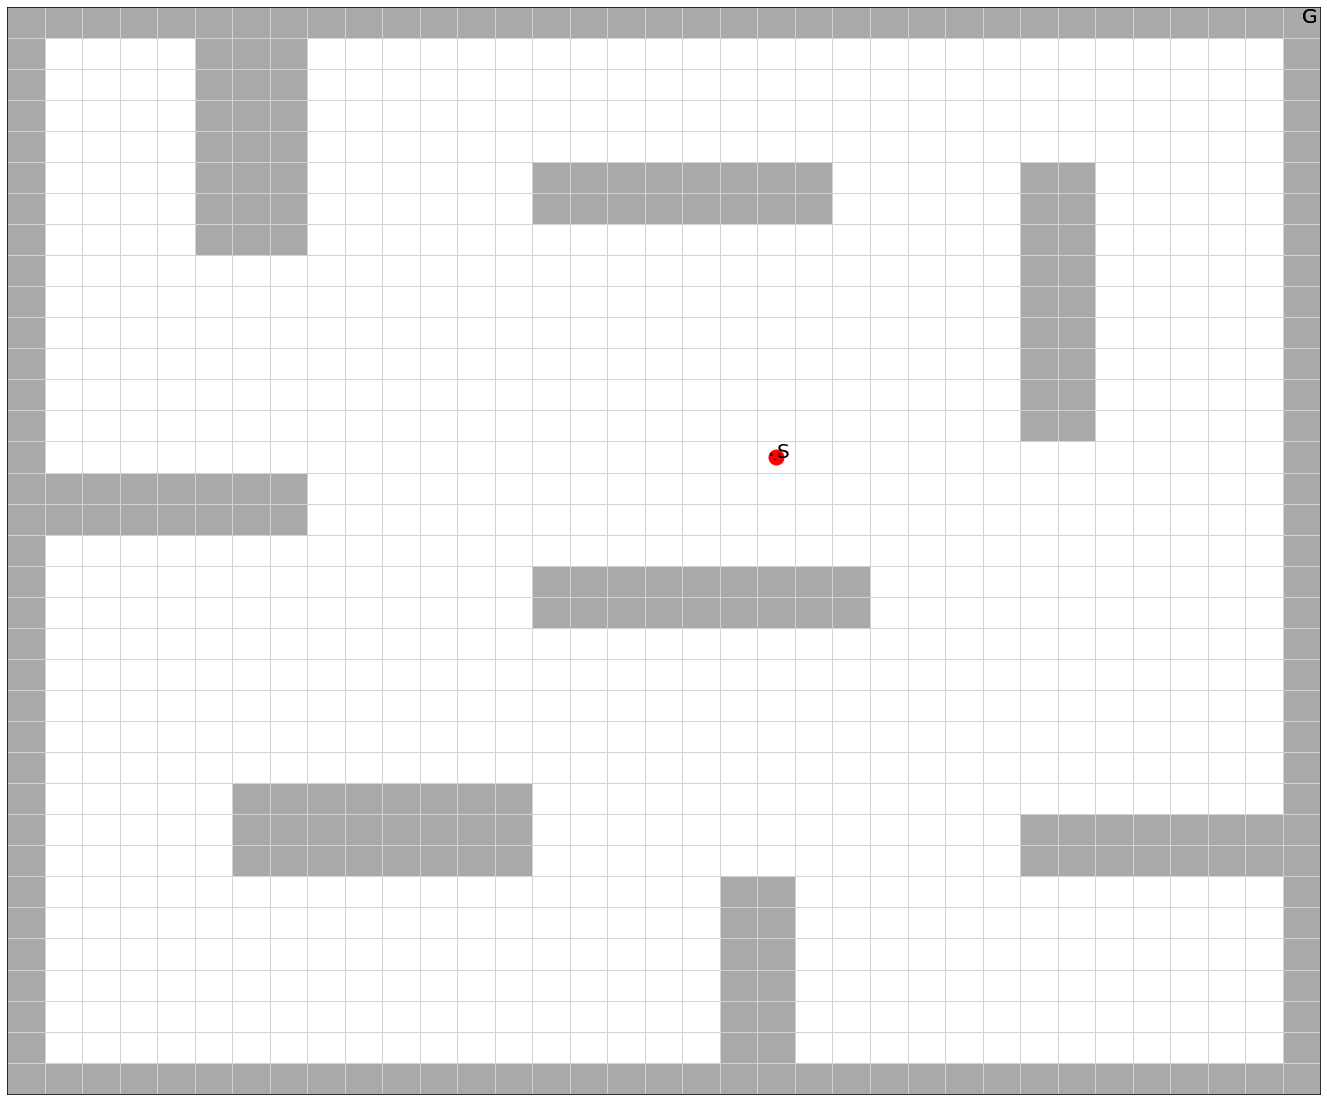

In [433]:
# Create a Grid object with custom figsize
gw = Grid(style='maze', figsize=(80, 20))
gw.render()



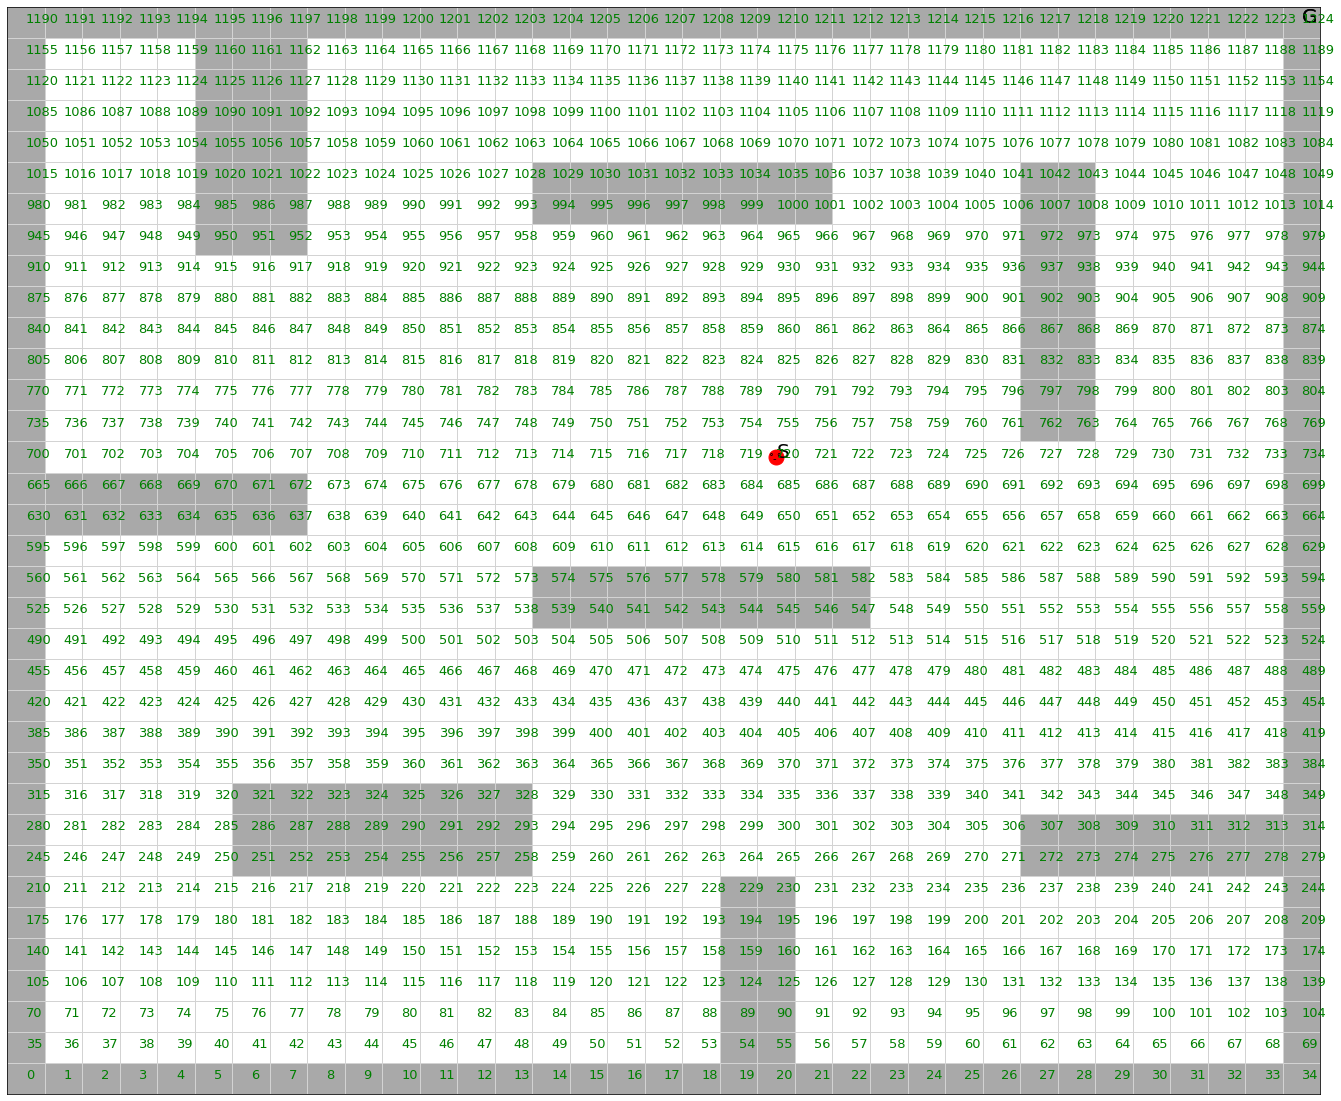

In [434]:
gw.render(underhood='states')